In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import asc, col, isnan, when, count, median, udf, concat, month, year, substring, lit, desc
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import os
import pyarrow
import pandas as pd

In [2]:
#Create a pyspark session and read the data
conf = SparkConf() \
    .setAppName("data_ana") \
    .set("spark.driver.memory", "12g")\
    .set("spark.executor.cores","8") \
    .set("spark.sql.execution.arrow.pyspark.enabled","true")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

csv_file_path ="/workspace/data.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
# df = spark.read.csv("/workspace/data.csv",header=True, inferSchema=True)
# df.orderBy(asc("fecha_dato"))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/23 08:41:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/23 08:41:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
#Cast column to integer type
df = df.withColumn("ncodpers", df["ncodpers"].cast(IntegerType()))
df = df.withColumn("ind_nomina_ult1", df["ind_nomina_ult1"].cast(IntegerType()))
df = df.withColumn("ind_nom_pens_ult1", df["ind_nom_pens_ult1"].cast(IntegerType()))

In [ ]:
# feature_list = [ "ind_ahor_fin_ult1",
#     "ind_aval_fin_ult1",
#     "ind_cco_fin_ult1",
#     "ind_cder_fin_ult1",
#     "ind_cno_fin_ult1",
#     "ind_ctju_fin_ult1",
#     "ind_ctma_fin_ult1",
#     "ind_ctop_fin_ult1",
#     "ind_ctpp_fin_ult1",
#     "ind_deco_fin_ult1",
#     "ind_deme_fin_ult1",
#     "ind_dela_fin_ult1",
#     "ind_ecue_fin_ult1",
#     "ind_fond_fin_ult1",
#     "ind_hip_fin_ult1",
#     "ind_plan_fin_ult1",
#     "ind_pres_fin_ult1",
#     "ind_reca_fin_ult1",
#     "ind_tjcr_fin_ult1",
#     "ind_valo_fin_ult1",
#     "ind_viv_fin_ult1",
#     "ind_nomina_ult1",
#     "ind_nom_pens_ult1",
#     "ind_recibo_ult1"]

# feature_cols = [F.col(col) for col in feature_list]
# features_array = F.array(*feature_cols).alias("features")

# grouped_df = df.select("ncodpers", *feature_list).withColumn("features", features_array) \
#     .groupBy("ncodpers") \
#     .agg(F.collect_list("features").alias("features_list"))

# customer_feature = {row["ncodpers"]: row["features_list"] for row in grouped_df.collect()}
# counts = {feature: 0 for feature in feature_list}

# for features in customer_feature.values():
#     for feat_array in features:
#         for idx, val in enumerate(feat_array):
#             counts[feature_list[idx]] += 1 if val == 1 else 0

In [ ]:
counts

{'ind_ahor_fin_ult1': 1354,
 'ind_aval_fin_ult1': 316,
 'ind_cco_fin_ult1': 8630654,
 'ind_cder_fin_ult1': 5339,
 'ind_cno_fin_ult1': 1072189,
 'ind_ctju_fin_ult1': 124182,
 'ind_ctma_fin_ult1': 127940,
 'ind_ctop_fin_ult1': 1718677,
 'ind_ctpp_fin_ult1': 574565,
 'ind_deco_fin_ult1': 23447,
 'ind_deme_fin_ult1': 22056,
 'ind_dela_fin_ult1': 570370,
 'ind_ecue_fin_ult1': 1097776,
 'ind_fond_fin_ult1': 246662,
 'ind_hip_fin_ult1': 78591,
 'ind_plan_fin_ult1': 122971,
 'ind_pres_fin_ult1': 34674,
 'ind_reca_fin_ult1': 699244,
 'ind_tjcr_fin_ult1': 591196,
 'ind_valo_fin_ult1': 342038,
 'ind_viv_fin_ult1': 51348,
 'ind_nomina_ult1': 725125,
 'ind_nom_pens_ult1': 787848,
 'ind_recibo_ult1': 1695166}

In [ ]:
# flist = feature_list = [ "ncodpers","ind_ahor_fin_ult1",
#     "ind_aval_fin_ult1",
#     "ind_cco_fin_ult1",
#     "ind_cder_fin_ult1",
#     "ind_cno_fin_ult1",
#     "ind_ctju_fin_ult1",
#     "ind_ctma_fin_ult1",
#     "ind_ctop_fin_ult1",
#     "ind_ctpp_fin_ult1",
#     "ind_deco_fin_ult1",
#     "ind_deme_fin_ult1",
#     "ind_dela_fin_ult1",
#     "ind_ecue_fin_ult1",
#     "ind_fond_fin_ult1",
#     "ind_hip_fin_ult1",
#     "ind_plan_fin_ult1",
#     "ind_pres_fin_ult1",
#     "ind_reca_fin_ult1",
#     "ind_tjcr_fin_ult1",
#     "ind_valo_fin_ult1",
#     "ind_viv_fin_ult1",
#     "ind_nomina_ult1",
#     "ind_nom_pens_ult1",
#     "ind_recibo_ult1"]

# from pyspark.sql import functions as F
# from pyspark.sql.functions import array, expr, col

# comp = df.filter("fecha_dato = '2016-05-28'").select(flist)

# # List of feature columns in comp (all except "ncodpers")
# feature_cols = [c for c in comp.columns if c != "ncodpers"]

# # Join submission and comp on "ncodpers"
# joined_df = submission.join(comp, "ncodpers", "inner")

# # Build an expression to create an array of actual products where the value is 1.
# # For each feature, we output the product name if value==1, else null.
# cases = [f"CASE WHEN {c} = 1 THEN '{c}' ELSE null END" for c in feature_cols]
# array_expr = "filter(array({}), x -> x is not null)".format(", ".join(cases))
# joined_df = joined_df.withColumn("actual_products", expr(array_expr))

# # Create a flag "correct" = 1 if the submitted product is present in the actual products array, else 0.
# joined_df = joined_df.withColumn("correct", F.when(F.array_contains(F.col("actual_products"), F.col("added_products")), 1).otherwise(0))

# # For each customer, since the prediction is a ranked list of one element, the average precision equals the correctness.
# joined_df = joined_df.withColumn("avg_precision", F.col("correct"))

# # Compute overall accuracy and MAP score
# metrics = joined_df.agg(
#     F.avg("correct").alias("accuracy"),
#     F.avg("avg_precision").alias("MAP")
# ).collect()[0]

# print("Accuracy:", metrics["accuracy"])
# print("MAP Score:", metrics["MAP"])

In [ ]:
# feature_occur_times = spark.createDataFrame(list(counts.items()), ["feature", "count"])

In [ ]:
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))

# Assume the first 24 columns are metadata; the remaining columns are target product indicators
all_columns = df.columns
target_cols = all_columns[24:]

# Define a window partitioned by customer (ncodpers) ordered by date
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# Compute lag of fecha_dato and each target column for each customer
df = df.withColumn("prev_fecha", F.lag("fecha_dato").over(w))
for col in target_cols:
    df = df.withColumn(f"prev_{col}", F.lag(col).over(w))

# For each target product column, flag rows that become 1 from a previous 0
# and where the date difference is less than 32 days
for col in target_cols:
    df = df.withColumn(f"{col}_new",
        F.when(
            (F.col(f"prev_{col}") == 0) & 
            (F.col(col) == 1) & 
            (F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32),
            1
        ).otherwise(0)
    )

# Now, aggregate by fecha_dato to obtain the monthly new product counts
agg_exprs = [F.sum(f"{col}_new").alias(col) for col in target_cols]
monthly_new_counts = df.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

monthly_new_counts.show()

25/02/19 15:19:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+---------------+-----------------+---------------+
|fecha_dato|ind_ahor_fin_ult1|ind_aval_fin_ult1|ind_cco_fin_ult1|ind_cder_fin_ult1|ind_cno_fin_ult1|ind_ctju_fin_ult1|ind_ctma_fin_ult1|ind_ctop_fin_ult1|ind_ctpp_fin_ult1|ind_deco_fin_ult1|ind_deme_fin_ult1|ind_dela_fin_ult1|ind_ecue_fin_ult1|ind_fond_fin_ult1|ind_hip_fin_ult1|ind_plan_fin_ult1|ind_pres_fin_ult1|ind_reca_fin_ult1|ind_tjcr_fin_ult1|ind_valo_fin_ult1|ind_viv_fin_ult1|ind_nomina_ult1|ind_nom_pens_ult1|ind_recibo_ult1|
+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+--------

In [ ]:
# Create lagged fecha_dato
#df = df.withColumn("prev_fecha", F.lag("fecha_dato").over(w))

# Create lagged target columns for each product
for col in target_cols:
    df = df.withColumn(f"prev_{col}", F.lag(col).over(w))

# For each target product column, flag rows where the product is dropped:
# (transition from 1 to 0) with days difference < 32.
for col in target_cols:
    df = df.withColumn(f"{col}_left",
            F.when(
            (F.col(f"prev_{col}") == 1) & 
            (F.col(col) == 0) & 
            (F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32),
            1
            ).otherwise(0)
        )

# Aggregate by fecha_dato to obtain the monthly user leave counts for each product
agg_exprs = [F.sum(f"{col}_left").alias(col) for col in target_cols]
monthly_leave_counts = df.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

monthly_leave_counts.show()

+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+---------------+-----------------+---------------+
|fecha_dato|ind_ahor_fin_ult1|ind_aval_fin_ult1|ind_cco_fin_ult1|ind_cder_fin_ult1|ind_cno_fin_ult1|ind_ctju_fin_ult1|ind_ctma_fin_ult1|ind_ctop_fin_ult1|ind_ctpp_fin_ult1|ind_deco_fin_ult1|ind_deme_fin_ult1|ind_dela_fin_ult1|ind_ecue_fin_ult1|ind_fond_fin_ult1|ind_hip_fin_ult1|ind_plan_fin_ult1|ind_pres_fin_ult1|ind_reca_fin_ult1|ind_tjcr_fin_ult1|ind_valo_fin_ult1|ind_viv_fin_ult1|ind_nomina_ult1|ind_nom_pens_ult1|ind_recibo_ult1|
+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+--------

In [ ]:
#Count the appearance of customer in one month and count the number of month that customer use product
total_counts = df.groupBy("ncodpers").agg(F.count("*").alias("total_count"))
total_counts.show()

# Count distinct months a customer appears in (assuming fecha_dato represents the month)
distinct_month_counts = df.groupBy("ncodpers").agg(F.countDistinct("fecha_dato").alias("month_count"))
distinct_month_counts.show()

+--------+-----------+
|ncodpers|total_count|
+--------+-----------+
| 1050607|         17|
| 1050426|         17|
| 1051867|         17|
| 1051742|         17|
| 1051547|         17|
| 1051451|         17|
| 1048661|         17|
| 1048726|         17|
| 1049332|         17|
| 1049636|         17|
| 1055946|         17|
| 1056289|         17|
| 1056442|         17|
| 1056379|         17|
| 1053078|         17|
| 1053660|         17|
| 1055076|         17|
| 1053861|         17|
| 1054452|         17|
| 1044242|         17|
+--------+-----------+
only showing top 20 rows



+--------+-----------+
|ncodpers|month_count|
+--------+-----------+
| 1050426|         17|
| 1046377|         17|
| 1119124|         17|
| 1092727|         17|
|  921353|         17|
| 1279760|         17|
| 1357617|         17|
| 1326869|         17|
| 1219766|         17|
|  292608|         17|
|  386998|         17|
|  404885|         17|
|   88674|         17|
|  114503|         17|
|   41575|         17|
|   27974|         17|
|  196013|         17|
|  120899|         17|
|  560682|         17|
|  515751|         17|
+--------+-----------+
only showing top 20 rows



In [ ]:
month_counts = df.groupBy("ncodpers").agg(
    F.countDistinct("fecha_dato").alias("month_count")
)

In [ ]:
# Create a new column for month from fecha_dato if not already defined
# df = df.withColumn("month_int", F.month("fecha_dato"))
# Get distinct customer-month combinations
customer_month = df.select("ncodpers", "fecha_dato").distinct()

# Pivot the DataFrame so that each customer becomes a row and each month becomes a column.
# Customers get a 1 if they appear in that month.
customer_appear_month = customer_month.groupBy("ncodpers") \
    .pivot("fecha_dato") \
    .agg(F.lit(1)) \
    .fillna(0)

customer_appear_month.orderBy(asc("ncodpers")).show()

+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|ncodpers|2015-01-28|2015-02-28|2015-03-28|2015-04-28|2015-05-28|2015-06-28|2015-07-28|2015-08-28|2015-09-28|2015-10-28|2015-11-28|2015-12-28|2016-01-28|2016-02-28|2016-03-28|2016-04-28|2016-05-28|
+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|   15889|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|
|   15890|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|
|   15891|

In [ ]:
# customer_month.orderBy(asc("ncodpers"),asc("fecha_dato")).show(6)

+--------+----------+
|ncodpers|fecha_dato|
+--------+----------+
|   15889|2015-01-28|
|   15889|2015-02-28|
|   15889|2015-03-28|
|   15889|2015-04-28|
|   15889|2015-05-28|
|   15889|2015-06-28|
+--------+----------+
only showing top 6 rows



In [ ]:
first_appearance = df.groupBy("ncodpers").agg(F.min("fecha_dato"))
first_appearance.show(5)

+--------+---------------+
|ncodpers|min(fecha_dato)|
+--------+---------------+
| 1050607|     2015-01-28|
| 1050426|     2015-01-28|
| 1051867|     2015-01-28|
| 1051742|     2015-01-28|
| 1051547|     2015-01-28|
+--------+---------------+
only showing top 5 rows



In [ ]:
avg_renta = df.select("nomprov","renta").distinct().filter(F.col("nomprov").isNotNull())

avg_renta = avg_renta.groupBy("nomprov").agg(F.round(F.avg("renta"),2).alias("avg_renta"))
avg_renta.orderBy(desc("avg_renta")).show(5)

+--------------+---------+
|       nomprov|avg_renta|
+--------------+---------+
|         CEUTA|177170.26|
|        MADRID| 169664.0|
|     BARCELONA| 161445.8|
|BALEARS, ILLES|161428.15|
|        GIRONA|146254.43|
+--------------+---------+
only showing top 5 rows



In [ ]:
# first_appearance = first_appearance.toPandas()
# conn.sql("CREATE TABLE first_appearance AS SELECT * FROM first_appearance")
# avg_renta = avg_renta.toPandas()
# conn.sql("CREATE TABLE avg_renta AS SELECT * FROM avg_renta")
# feature_occur_times = feature_occur_times.toPandas()
# conn.sql("CREATE TABLE feature_occur_times AS SELECT * FROM feature_occur_times")
# customer_appear_month = customer_appear_month.toPandas()
# conn.sql("CREATE TABLE customer_appear_month AS SELECT * FROM customer_appear_month")
# monthly_leave_counts = monthly_leave_counts.toPandas()
# conn.sql("CREATE TABLE monthly_leave_counts AS SELECT * FROM monthly_leave_counts")
# monthly_new_counts = monthly_new_counts.toPandas()
# conn.sql("CREATE TABLE monthly_new_counts AS SELECT * FROM monthly_new_counts")
# total_counts = total_counts.toPandas()
# conn.sql("CREATE TABLE total_counts AS SELECT * FROM total_counts")
# distinct_month_counts = distinct_month_counts.toPandas()
# conn.sql("CREATE TABLE distinct_month_counts AS SELECT * FROM distinct_month_counts")

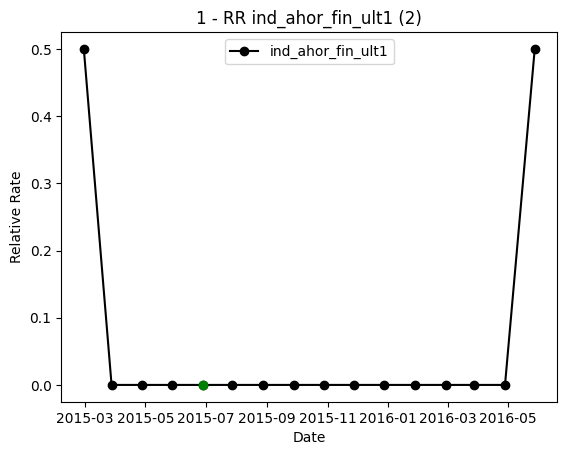

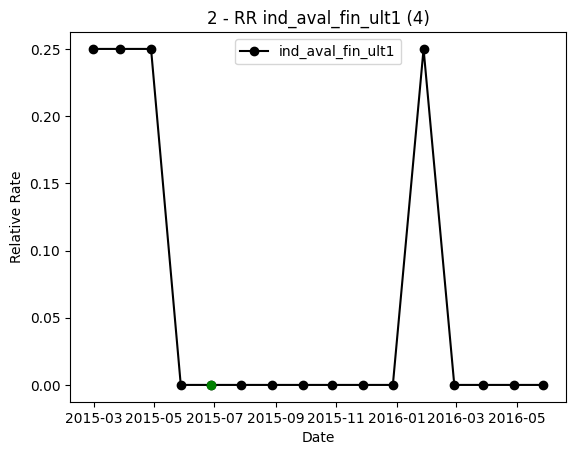

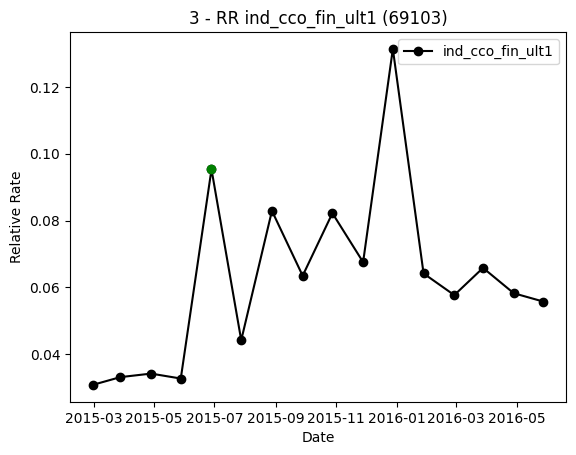

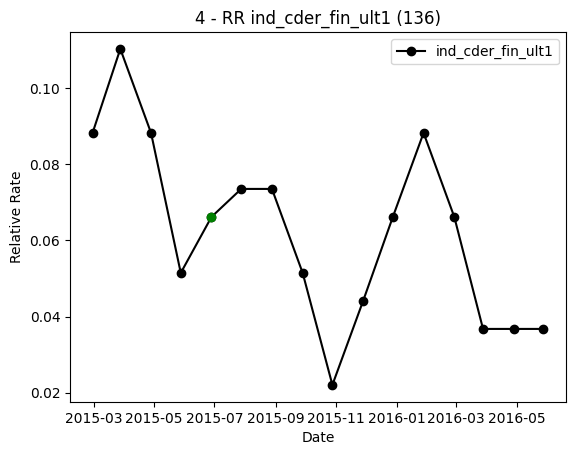

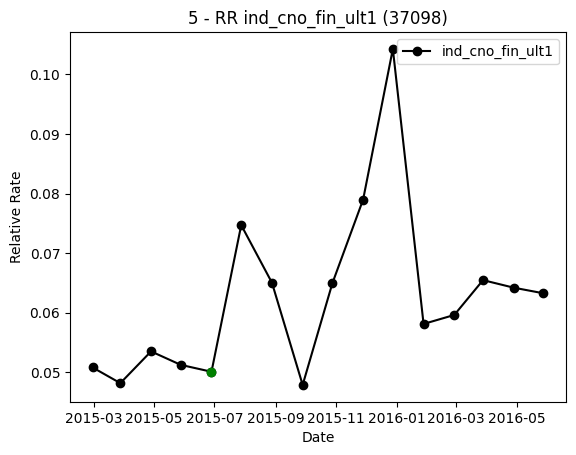

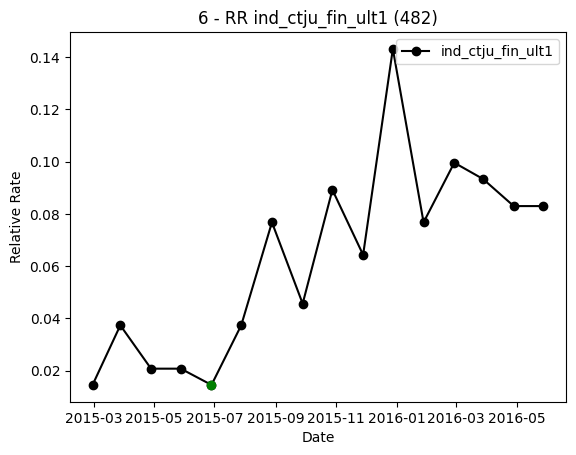

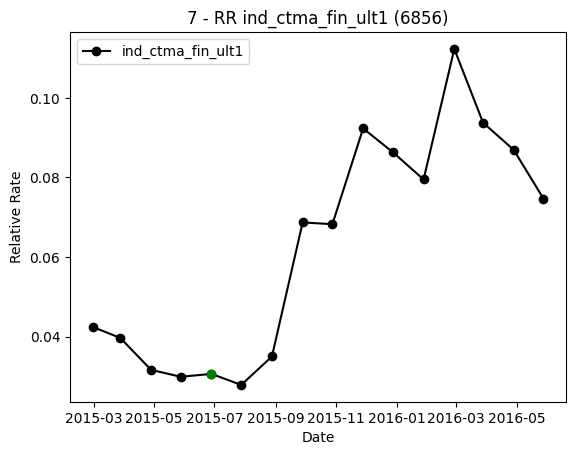

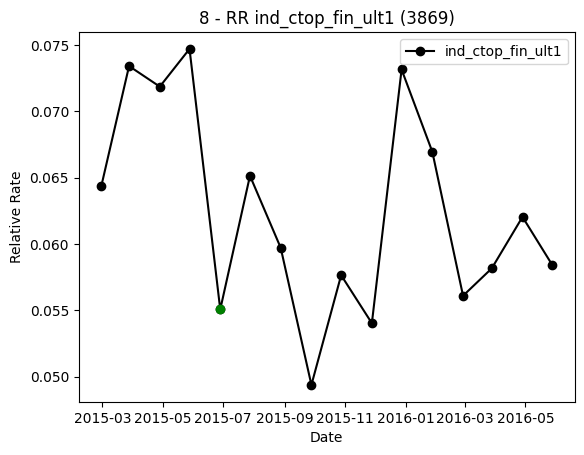

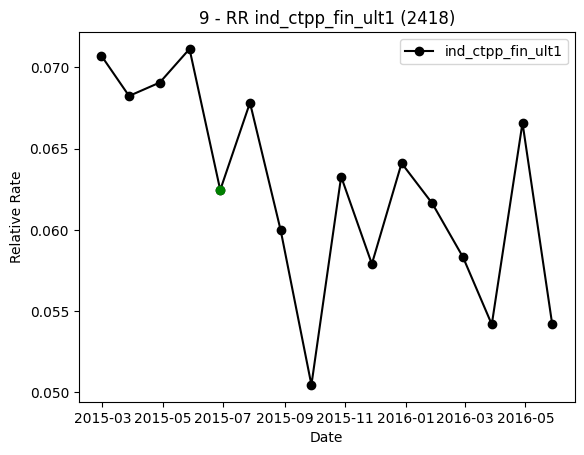

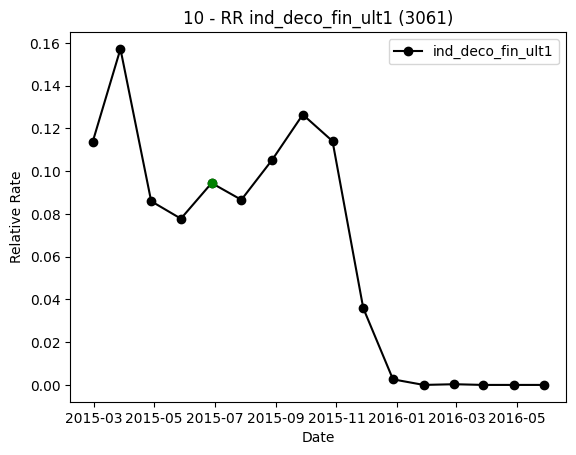

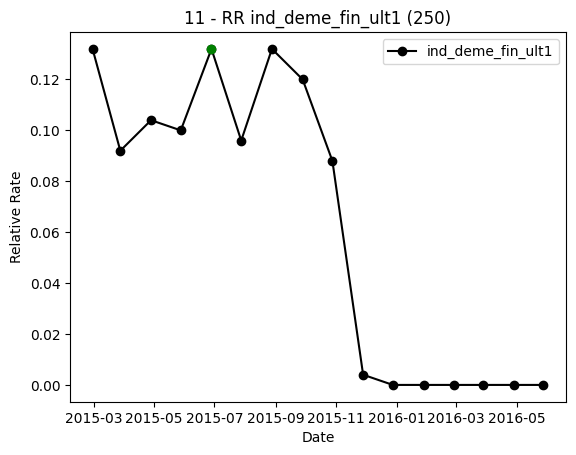

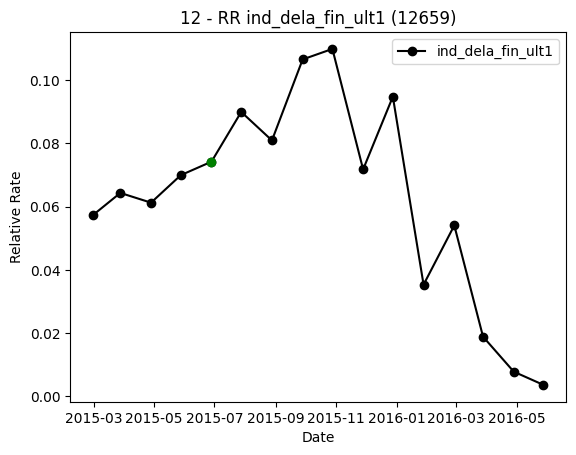

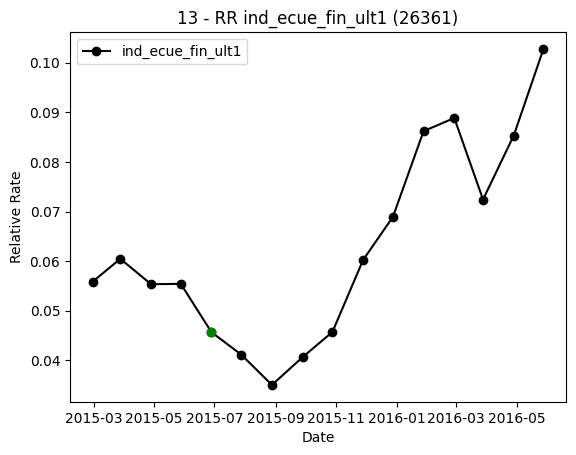

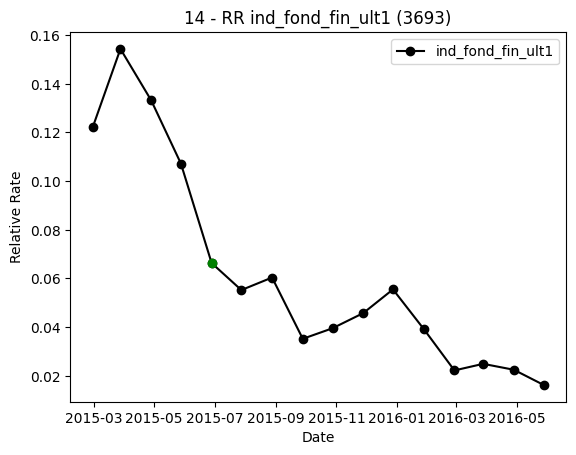

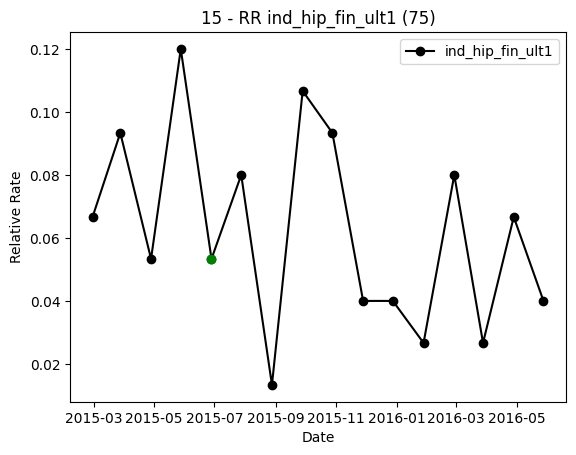

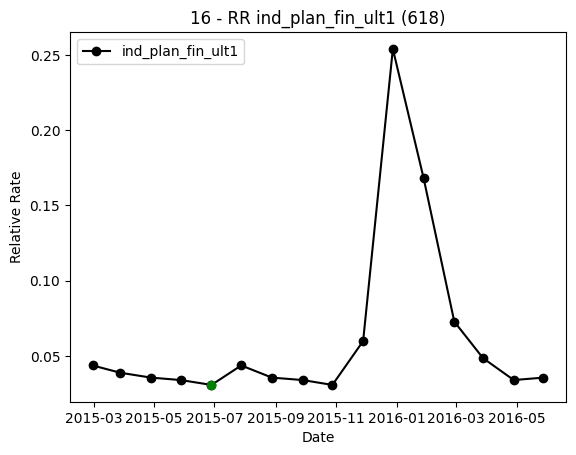

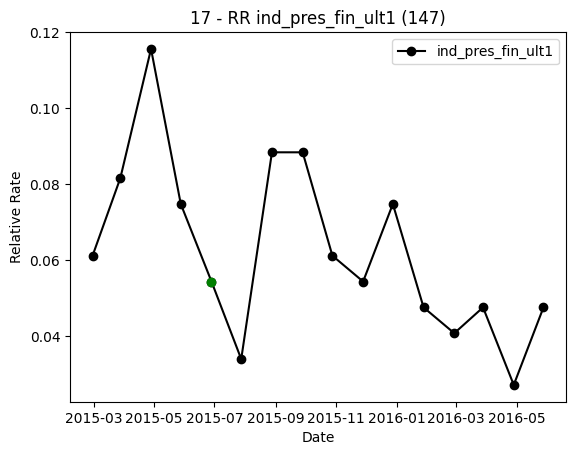

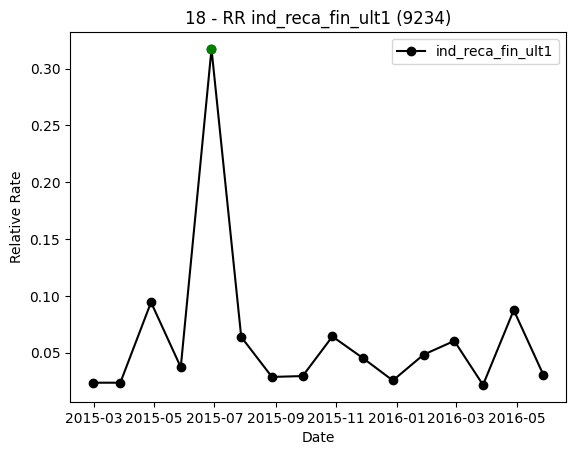

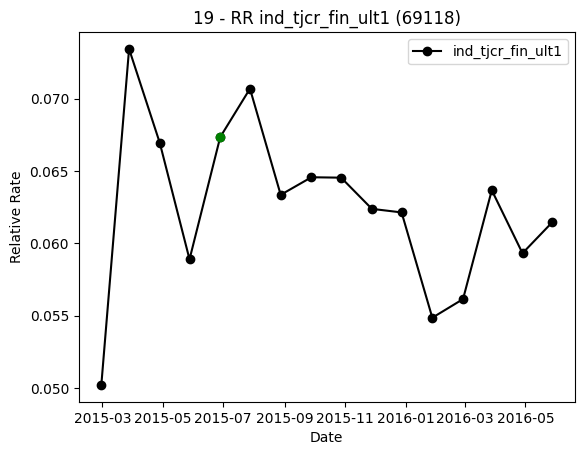

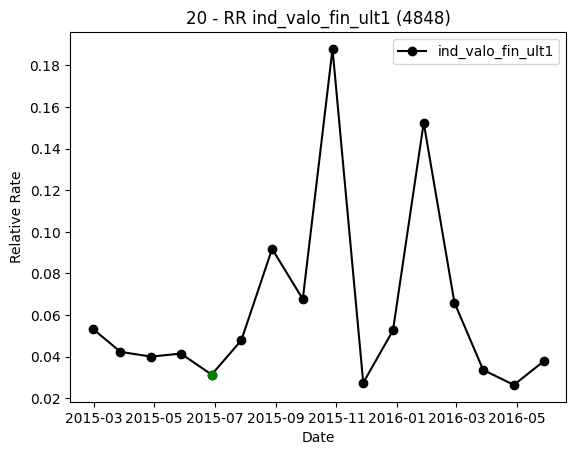

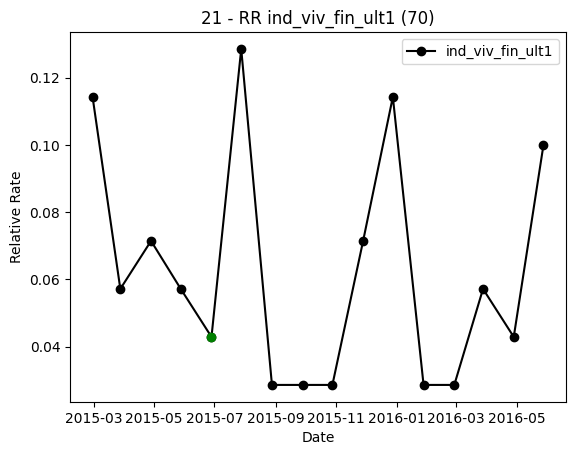

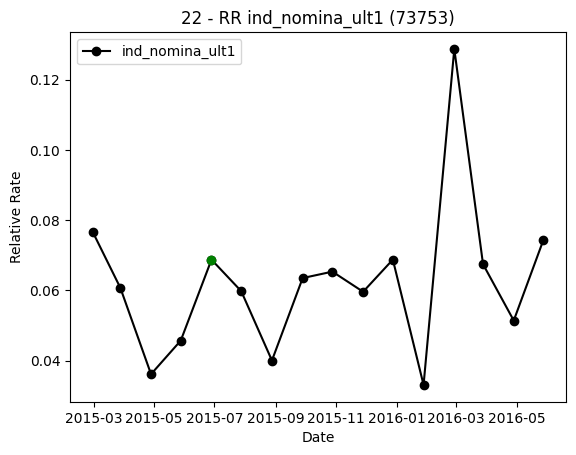

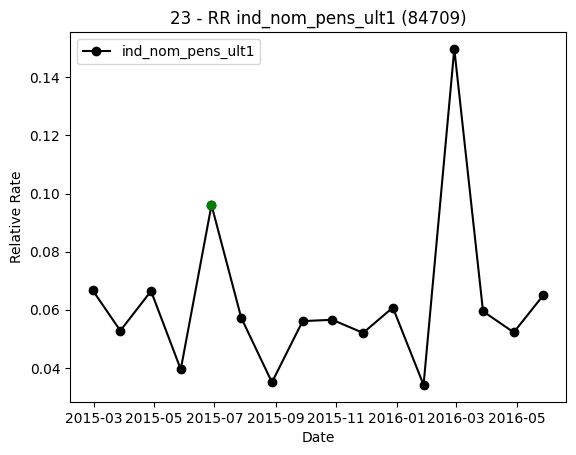

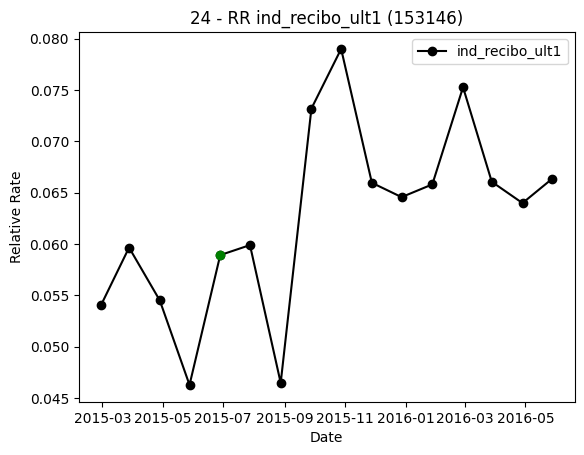

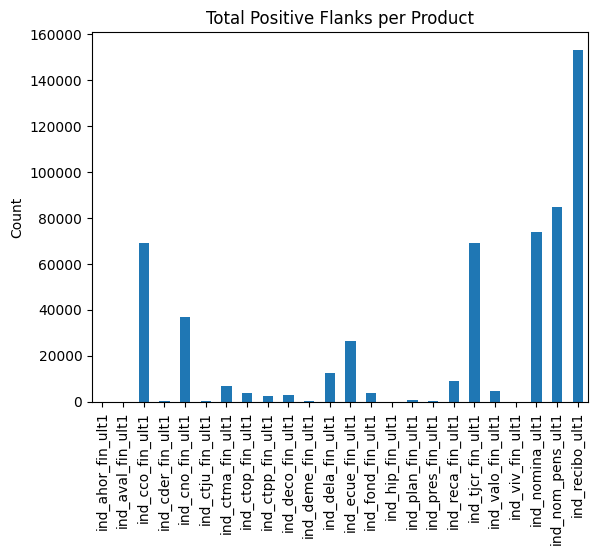

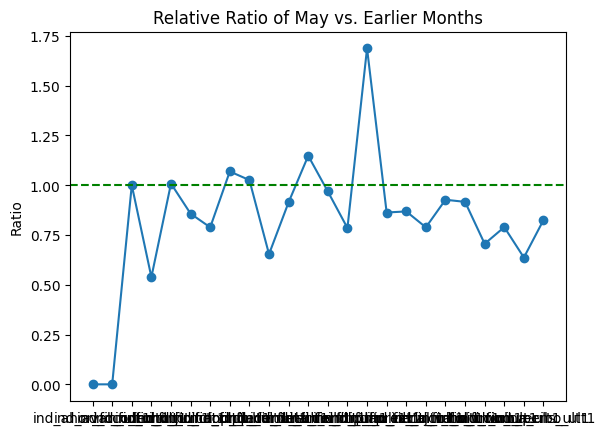

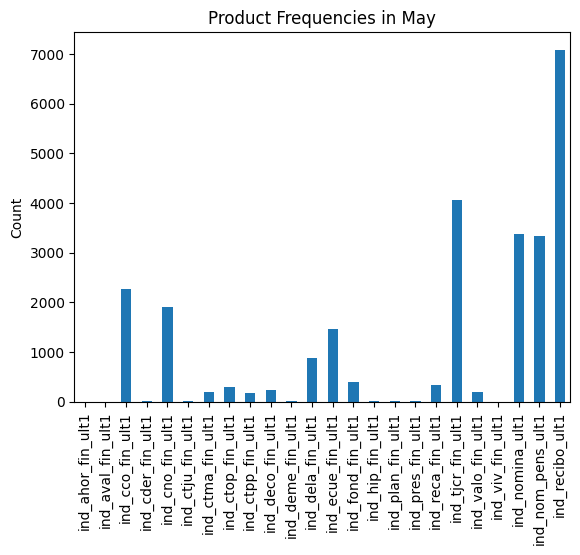

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Ensure fecha_dato is in date format
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))

# Define target product columns (all columns from index 24 onward)
targetCols = df.columns[24:]
nbTargetCols = len(targetCols)

# Get sorted unique dates (skip the first one as in the R code)
sorted_dates = [r.fecha_dato for r in df.select("fecha_dato").distinct().orderBy("fecha_dato").collect()][1:]
nbDates = len(sorted_dates)

# Create a window partitioned by client (ncodpers) ordered by fecha_dato
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# Add lag columns: lag_fecha and for each product the lag value
df = df.withColumn("lag_fecha", F.lag("fecha_dato").over(w))
for t in targetCols:
    df = df.withColumn(f"lag_{t}", F.lag(F.col(t)).over(w))

targetCols = [c for c in df.columns[24:] if not c.startswith("lag_")]
nbTargetCols = len(targetCols)

# For each product, flag positive flank occurrences:
# Condition: for a given product, previous value equals 0 and current equals 1,
# and the difference in fecha_dato is less than 32 days.
all_counts = {}
for t in targetCols:
    pos_cond = (F.col(t) == 1) & (F.col(f"lag_{t}") == 0) & (F.datediff(F.col("fecha_dato"), F.col("lag_fecha")) < 32)
    df_flag = df.withColumn("positive_flank", F.when(pos_cond, 1).otherwise(0))
    
    # Group by fecha_dato and count positive flanks for this product
    prod_counts = df_flag.groupBy("fecha_dato").agg(F.sum("positive_flank").alias("count"))
    # Convert to Pandas, ensure the index covers all sorted_dates (missing dates -> 0)
    prod_pd = prod_counts.toPandas()
    prod_pd['fecha_dato'] = pd.to_datetime(prod_pd['fecha_dato'])
    prod_pd = prod_pd.set_index('fecha_dato').reindex(sorted_dates, fill_value=0)
    all_counts[t] = prod_pd['count']

# Combine all product counts into a DataFrame (rows: months, columns: products)
allCounts_pdf = pd.DataFrame(all_counts, index=sorted_dates)

# ----- Plot relative monthly fractions for each product -----
for i, t in enumerate(targetCols):
    counts = allCounts_pdf[t]
    frac = counts / counts.sum() if counts.sum() != 0 else counts
    plt.figure()
    plt.plot(sorted_dates, frac, marker='o', color='black', label=t)
    if len(sorted_dates) >= 5:
        plt.plot(sorted_dates[4], frac.iloc[4], marker='o', color='green')
    plt.title(f"{i+1} - RR {t} ({counts.sum()})")
    plt.xlabel("Date")
    plt.ylabel("Relative Rate")
    plt.legend()
    plt.show()
    plt.pause(2)

# ----- Overall Influence: Compute row-wise fractions -----
row_sums = allCounts_pdf.sum(axis=1)
overall_frac = allCounts_pdf.divide(row_sums, axis=0)

# ----- Relative Ratios Calculation -----
# For May (4th row: index 3) vs. first three months (rows 0 to 2)
if allCounts_pdf.shape[0] >= 4:
    relativeRatiosMay = allCounts_pdf.iloc[3] / allCounts_pdf.iloc[:3].mean(axis=0)
else:
    relativeRatiosMay = pd.Series(0, index=targetCols)

# ----- Plotting -----
# Total positive flanks per product
nbPosFlanks = allCounts_pdf.sum(axis=0)
plt.figure()
nbPosFlanks.plot(kind="bar")
plt.title("Total Positive Flanks per Product")
plt.ylabel("Count")
plt.show()

# Relative ratio of May versus earlier months
plt.figure()
plt.plot(relativeRatiosMay, marker='o')
plt.axhline(y=1, color="green", linestyle="--")
plt.title("Relative Ratio of May vs. Earlier Months")
plt.ylabel("Ratio")
plt.show()

# Product frequencies in May (5th month)
if allCounts_pdf.shape[0] >= 4:
    mayCount = allCounts_pdf.iloc[3]
    plt.figure()
    mayCount.plot(kind="bar")
    plt.title("Product Frequencies in May")
    plt.ylabel("Count")
    plt.show()

In [ ]:
spark = SparkSession.builder.appName("FeatureImpactToMAP").getOrCreate()

# Load the raw training data
df = spark.read.csv("/workspace/data.csv", header=True, inferSchema=True)

# Convert date column and calculate a numerical month (year*12 + month)


# Assume that product indicator columns start from column index 24 onward
all_cols = df.columns
productCols = all_cols[24:]  # adjust if needed

df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))
df = df.withColumn("month_value", F.expr("year(fecha_dato)*12 + month(fecha_dato)"))

# Create a window partitioned by customer and ordered by fecha_dato
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# For each product column, compute the lagged value and then a new-adoption indicator: 1 if current minus lag equals 1, else 0.
for col in productCols:
    df = df.withColumn(f"lag_{col}", F.lag(F.col(col)).over(w)) \
           .withColumn(f"new_{col}", F.when(F.col(col) - F.col(f"lag_{col}") == 1, 1).otherwise(0))

# Compute, per row, the total number of new product adoptions
newIndicators = [F.col(f"new_{col}") for col in productCols]
df = df.withColumn("user_new_count", sum(newIndicators))

# We skip the first record per customer (where lag is null) and consider rows with at least one new product
df_filtered = df.filter(F.col("user_new_count") > 0)

# For each product, compute the per-row contribution as new_indicator/user_new_count
for col in productCols:
    df_filtered = df_filtered.withColumn(f"ratio_{col}", F.col(f"new_{col}")/F.col("user_new_count"))

# Now group by the current month (we use the fecha_dato as proxy) to aggregate the relative contribution per product.
agg_exprs = [F.avg(f"ratio_{col}").alias(col) for col in productCols]
month_contrib = df_filtered.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

# Optionally, display the monthly contributions
month_contrib.show(10, truncate=False)

# To summarize the MAP impact per feature over time, average the monthly contributions
feature_impact = month_contrib.agg(*[F.avg(col).alias(col) for col in productCols]).collect()[0].asDict()

print("Feature impact to MAP (average relative contribution):")
for feature, impact in feature_impact.items():
    print(f"Feature: {feature}, Impact: {impact}")

spark.stop()

25/02/22 08:54:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+----------+--------------------+---------------------+-------------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+--------------------+---------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------------+--------------------+-------------------+---------------------+---------------------+-------------------+--------------------+-------------------+
|fecha_dato|ind_ahor_fin_ult1   |ind_aval_fin_ult1    |ind_cco_fin_ult1   |ind_cder_fin_ult1    |ind_cno_fin_ult1    |ind_ctju_fin_ult1    |ind_ctma_fin_ult1    |ind_ctop_fin_ult1    |ind_ctpp_fin_ult1    |ind_deco_fin_ult1   |ind_deme_fin_ult1    |ind_dela_fin_ult1   |ind_ecue_fin_ult1   |ind_fond_fin_ult1    |ind_hip_fin_ult1     |ind_plan_fin_ult1    |ind_pres_fin_ult1    |ind_reca_fin_ult1   |ind_tjcr_fin_ult1  |ind_valo_fin_ult1    |ind_viv_fin_ult1     |ind_nomina

Feature impact to MAP (average relative contribution):
Feature: ind_ahor_fin_ult1, Impact: 4.8668974473910096e-06
Feature: ind_aval_fin_ult1, Impact: 7.502198361950876e-06
Feature: ind_cco_fin_ult1, Impact: 0.14510654146207663
Feature: ind_cder_fin_ult1, Impact: 0.0002918543209216859
Feature: ind_cno_fin_ult1, Impact: 0.05667512817128662
Feature: ind_ctju_fin_ult1, Impact: 0.0010599548150987763
Feature: ind_ctma_fin_ult1, Impact: 0.013773749073804426
Feature: ind_ctop_fin_ult1, Impact: 0.0081723201117575
Feature: ind_ctpp_fin_ult1, Impact: 0.005063561250791425
Feature: ind_deco_fin_ult1, Impact: 0.006708057449252034
Feature: ind_deme_fin_ult1, Impact: 0.0005378761174419628
Feature: ind_dela_fin_ult1, Impact: 0.025825218204232208
Feature: ind_ecue_fin_ult1, Impact: 0.05455949353969518
Feature: ind_fond_fin_ult1, Impact: 0.007666865591147999
Feature: ind_hip_fin_ult1, Impact: 0.00013610065665735181
Feature: ind_plan_fin_ult1, Impact: 0.001168426458703856
Feature: ind_pres_fin_ult1, Impac